In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from fastai.tabular.all import *
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from dtreeviz.trees import *

pd.options.display.max_rows = 60


In [118]:
save_dir = Path("./market/save")
df = pd.read_csv(save_dir / f"rdf_output.csv")


In [119]:
df.shape

(10000, 55)

In [120]:
df[['ns_since_open', 'ts_in_delta', 'ts_eventElapsed']]

,ns_since_open,ts_in_delta,ts_eventElapsed
0,3.481396e+12,166161,1.735918e+09
1,3.112521e+12,165897,1.735918e+09
2,3.043018e+12,166238,1.735918e+09
3,7.567390e+11,179730,1.735915e+09
4,1.720747e+12,167297,1.735916e+09
...,...,...,...
9995,1.983450e+12,166120,1.735917e+09
9996,1.730552e+12,166405,1.735916e+09
9997,6.836492e+11,166589,1.735915e+09
9998,2.868681e+12,166683,1.735917e+09


In [121]:
df.columns

Index(['ts_recv', 'ts_event', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'depth', 'price', 'size', 'flags', 'ts_in_delta',
       'sequence', 'symbol', 'ns_since_open', 'ts_eventYear', 'ts_eventMonth',
       'ts_eventWeek', 'ts_eventDay', 'ts_eventDayofweek', 'ts_eventDayofyear',
       'ts_eventIs_month_end', 'ts_eventIs_month_start',
       'ts_eventIs_quarter_end', 'ts_eventIs_quarter_start',
       'ts_eventIs_year_end', 'ts_eventIs_year_start', 'ts_eventElapsed',
       'spread', 'mid', 'bid_weight', 'ask_weight', 'bid_weight_log',
       'ask_weight_log', 'traded_bid_size', 'traded_ask_size', 'is_trade_bid',
       'is_trade_ask', 'rolling_30s_bid_size', 'rolling_30s_ask_size',
       'rolling_30s_bid_cnt', 'rolling_30s_ask_cnt', 'rolling_5min_bid_size',
       'rolling_5min_ask_size', 'rolling_5min_bid_cnt', 'rolling_5min_ask_cnt',
       'hedge_buy_stop_idx', 'hedge_sell_stop_idx', 'ideal_sell_price',
       'ideal_buy_price_spread', 'ideal_sell_price_s

#### Simplify the data further

In [122]:
columns_to_keep = ['instrument_id', 'symbol',
                   'ns_since_open', 'ts_eventYear', 'ts_eventMonth',
       'ts_eventWeek', 'ts_eventDay', 'ts_eventDayofweek', 'ts_eventDayofyear',
       'ts_eventIs_month_end', 'ts_eventIs_month_start',
       'ts_eventIs_quarter_end', 'ts_eventIs_quarter_start',
       'ts_eventIs_year_end', 'ts_eventIs_year_start', 'ts_eventElapsed',
       'spread', 
       #'mid', 
       'bid_weight', 'ask_weight', 'bid_weight_log',
       'ask_weight_log', 
       #'traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask', 
       'rolling_30s_bid_size', 'rolling_30s_ask_size',
       'rolling_30s_bid_cnt', 'rolling_30s_ask_cnt', 'rolling_5min_bid_size',
       'rolling_5min_ask_size', 'rolling_5min_bid_cnt', 'rolling_5min_ask_cnt',
       #'hedge_buy_stop_idx', 'hedge_sell_stop_idx', 
]
dep_vars = ['ideal_price_spread'] 

#       'ideal_buy_price', 'ideal_sell_price', 
#       'ideal_buy_price_spread', 'ideal_sell_price_spread']

rdf = df[columns_to_keep + dep_vars]

In [123]:
cont_cols,cat_cols = cont_cat_split(rdf, max_card=9000, dep_var=dep_vars)

In [124]:
print("********* Continuous columns")
[print(x) for x in cont_cols] 
print("********* Categorical columns")
_= [print(x) for x in cat_cols] 
#cont_cols

********* Continuous columns
ns_since_open
ts_eventElapsed
spread
bid_weight
ask_weight
bid_weight_log
ask_weight_log
rolling_30s_bid_size
rolling_30s_ask_size
rolling_30s_bid_cnt
rolling_30s_ask_cnt
rolling_5min_bid_size
rolling_5min_ask_size
rolling_5min_bid_cnt
rolling_5min_ask_cnt
********* Categorical columns
instrument_id
symbol
ts_eventYear
ts_eventMonth
ts_eventWeek
ts_eventDay
ts_eventDayofweek
ts_eventDayofyear
ts_eventIs_month_end
ts_eventIs_month_start
ts_eventIs_quarter_end
ts_eventIs_quarter_start
ts_eventIs_year_end
ts_eventIs_year_start


In [126]:
rdf[['spread', 'ideal_price_spread']].describe()

,spread,ideal_price_spread
count,10000.000000,10000.000000
mean,0.000125,5.206688
std,0.000050,59.947007
min,0.000069,-168.000000
25%,0.000070,-31.666667
50%,0.000139,0.500000
75%,0.000140,34.000000
max,0.000714,215.000000


In [127]:
procs_nn = [Categorify, FillMissing, Normalize]
test_set = rdf.sample(frac=0.2)
train_set = rdf.drop(test_set.index)
splits = (list(train_set.index), list(test_set.index))


to = TabularPandas(rdf, procs_nn, cat_cols, cont_cols,
                      splits=splits, y_names='ideal_price_spread')

In [128]:
xs,y = to.train.xs,to.train.y
m = DecisionTreeRegressor(max_leaf_nodes=10)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=10)

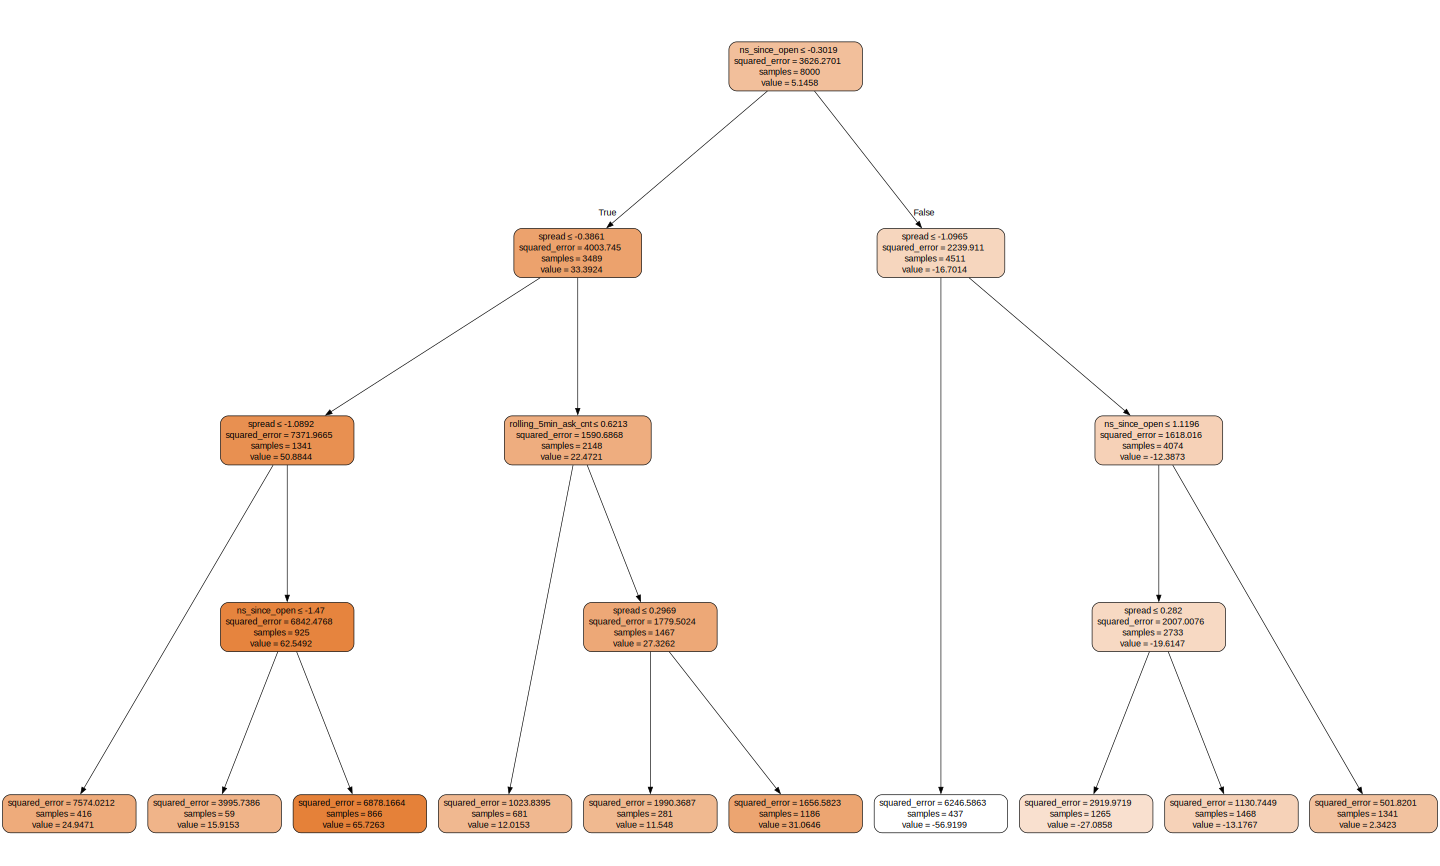

In [129]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    import graphviz
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, xs, size=20, leaves_parallel=True, precision=4, ratio=0.6)